In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [2]:
# Load Nutrient Data
csv_path = 'dataset/indian_dishes_nutrients.csv'  # Ensure columns: 'Food', 'Calories', 'Protein', 'Fat', 'Carbs'
data = pd.read_csv(csv_path)

# Handle missing values (drop or fill)
data.dropna(inplace=True)

# Split features and target
X_nutrients = data.drop(columns=['Food'])
y = data['Food']

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Encode AFTER splitting

# Normalize features
scaler = StandardScaler()
X_nutrients = scaler.fit_transform(X_nutrients)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with augmentation for better generalization
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1  # 10% for validation
)

image_size = (128, 128)
batch_size = 32

# Load training images
train_images = data_gen.flow_from_directory(
    'dataset/Indian Food Images',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Ensures one-hot encoding
    subset='training',
    shuffle=True  # Important for generalization
)

# Load validation images
val_images = data_gen.flow_from_directory(
    'dataset/Indian Food Images',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation',
    shuffle=True  # Ensures validation samples are randomized
)


Found 3600 images belonging to 80 classes.
Found 400 images belonging to 80 classes.


In [14]:
train_images.class_indices

{'adhirasam': 0,
 'aloo_gobi': 1,
 'aloo_matar': 2,
 'aloo_methi': 3,
 'aloo_shimla_mirch': 4,
 'aloo_tikki': 5,
 'anarsa': 6,
 'ariselu': 7,
 'bandar_laddu': 8,
 'basundi': 9,
 'bhatura': 10,
 'bhindi_masala': 11,
 'biryani': 12,
 'boondi': 13,
 'butter_chicken': 14,
 'chak_hao_kheer': 15,
 'cham_cham': 16,
 'chana_masala': 17,
 'chapati': 18,
 'chhena_kheeri': 19,
 'chicken_razala': 20,
 'chicken_tikka': 21,
 'chicken_tikka_masala': 22,
 'chikki': 23,
 'daal_baati_churma': 24,
 'daal_puri': 25,
 'dal_makhani': 26,
 'dal_tadka': 27,
 'dharwad_pedha': 28,
 'doodhpak': 29,
 'double_ka_meetha': 30,
 'dum_aloo': 31,
 'gajar_ka_halwa': 32,
 'gavvalu': 33,
 'ghevar': 34,
 'gulab_jamun': 35,
 'imarti': 36,
 'jalebi': 37,
 'kachori': 38,
 'kadai_paneer': 39,
 'kadhi_pakoda': 40,
 'kajjikaya': 41,
 'kakinada_khaja': 42,
 'kalakand': 43,
 'karela_bharta': 44,
 'kofta': 45,
 'kuzhi_paniyaram': 46,
 'lassi': 47,
 'ledikeni': 48,
 'litti_chokha': 49,
 'lyangcha': 50,
 'maach_jhol': 51,
 'makki_di_

In [15]:
class_names = list(train_images.class_indices.keys())
class_names

['adhirasam',
 'aloo_gobi',
 'aloo_matar',
 'aloo_methi',
 'aloo_shimla_mirch',
 'aloo_tikki',
 'anarsa',
 'ariselu',
 'bandar_laddu',
 'basundi',
 'bhatura',
 'bhindi_masala',
 'biryani',
 'boondi',
 'butter_chicken',
 'chak_hao_kheer',
 'cham_cham',
 'chana_masala',
 'chapati',
 'chhena_kheeri',
 'chicken_razala',
 'chicken_tikka',
 'chicken_tikka_masala',
 'chikki',
 'daal_baati_churma',
 'daal_puri',
 'dal_makhani',
 'dal_tadka',
 'dharwad_pedha',
 'doodhpak',
 'double_ka_meetha',
 'dum_aloo',
 'gajar_ka_halwa',
 'gavvalu',
 'ghevar',
 'gulab_jamun',
 'imarti',
 'jalebi',
 'kachori',
 'kadai_paneer',
 'kadhi_pakoda',
 'kajjikaya',
 'kakinada_khaja',
 'kalakand',
 'karela_bharta',
 'kofta',
 'kuzhi_paniyaram',
 'lassi',
 'ledikeni',
 'litti_chokha',
 'lyangcha',
 'maach_jhol',
 'makki_di_roti_sarson_da_saag',
 'malapua',
 'misi_roti',
 'misti_doi',
 'modak',
 'mysore_pak',
 'naan',
 'navrattan_korma',
 'palak_paneer',
 'paneer_butter_masala',
 'phirni',
 'pithe',
 'poha',
 'poornalu

In [16]:
from tensorflow.keras import layers, models, Input

# Image Model
image_input = Input(shape=(128, 128, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = layers.BatchNormalization()(x)  # Normalize feature maps
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.GlobalAveragePooling2D()(x)  # Better than Flatten for generalization
x = layers.Dropout(0.4)(x)  # Helps prevent overfitting
num_classes = len(class_names)  # Get the number of classes
image_output = layers.Dense(num_classes, activation='softmax')(x)




In [17]:
import numpy as np
from tensorflow.keras import layers

# Ensure y_encoded is properly defined (assuming it is the encoded labels from label encoding)
num_classes = len(np.unique(y))  # Dynamically determine number of classes

# Classification Layer
final_output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Use dynamic class count


In [18]:
from tensorflow.keras import models, optimizers

# Define the Model
model = models.Model(inputs=image_input, outputs=final_output)

# Compile the Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # Adjust if necessary
    loss='categorical_crossentropy',  # Matches integer-encoded labels
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print Model Summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 64)       256 

In [21]:
# Set Number of Epochs
epochs = 70  

# Train the Model
history = model.fit(
    train_images,
    epochs=epochs,
    validation_data=val_images,
    
)


Epoch 1/70
113/113 [==============================] - 48s 426ms/step - loss: 0.8996 - accuracy: 0.7708 - precision_2: 0.9194 - recall_2: 0.5544 - val_loss: 2.5561 - val_accuracy: 0.4100 - val_precision_2: 0.6686 - val_recall_2: 0.2925
Epoch 2/70
113/113 [==============================] - 48s 426ms/step - loss: 0.8601 - accuracy: 0.7775 - precision_2: 0.9220 - recall_2: 0.5711 - val_loss: 2.4110 - val_accuracy: 0.3925 - val_precision_2: 0.6809 - val_recall_2: 0.2400
Epoch 3/70
113/113 [==============================] - 48s 423ms/step - loss: 0.8396 - accuracy: 0.7864 - precision_2: 0.9165 - recall_2: 0.5794 - val_loss: 2.5621 - val_accuracy: 0.4125 - val_precision_2: 0.6412 - val_recall_2: 0.2725
Epoch 4/70
113/113 [==============================] - 47s 413ms/step - loss: 0.7811 - accuracy: 0.8008 - precision_2: 0.9268 - recall_2: 0.6119 - val_loss: 2.5048 - val_accuracy: 0.3950 - val_precision_2: 0.6601 - val_recall_2: 0.2525
Epoch 5/70
113/113 [==============================] - 47s 41

In [22]:
# Train the Model
history = model.fit(train_images, epochs=10, validation_data=val_images)

# Access Training Metrics (Using .get() to avoid errors)
train_acc = history.history.get('accuracy', [None])[-1]
val_acc = history.history.get('val_accuracy', [None])[-1]

train_precision = history.history.get('precision', [None])[-1]
val_precision = history.history.get('val_precision', [None])[-1]

train_recall = history.history.get('recall', [None])[-1]
val_recall = history.history.get('val_recall', [None])[-1]




Epoch 1/10
113/113 [==============================] - 48s 428ms/step - loss: 0.1414 - accuracy: 0.9617 - precision_2: 0.9740 - recall_2: 0.9467 - val_loss: 3.1970 - val_accuracy: 0.4100 - val_precision_2: 0.5305 - val_recall_2: 0.3475
Epoch 2/10
113/113 [==============================] - 48s 421ms/step - loss: 0.1391 - accuracy: 0.9614 - precision_2: 0.9725 - recall_2: 0.9436 - val_loss: 3.0365 - val_accuracy: 0.4350 - val_precision_2: 0.5616 - val_recall_2: 0.3875
Epoch 3/10
113/113 [==============================] - 46s 409ms/step - loss: 0.1374 - accuracy: 0.9650 - precision_2: 0.9755 - recall_2: 0.9497 - val_loss: 2.8675 - val_accuracy: 0.4450 - val_precision_2: 0.5593 - val_recall_2: 0.3775
Epoch 4/10
113/113 [==============================] - 48s 428ms/step - loss: 0.1376 - accuracy: 0.9631 - precision_2: 0.9737 - recall_2: 0.9461 - val_loss: 3.0571 - val_accuracy: 0.4100 - val_precision_2: 0.5423 - val_recall_2: 0.3525
Epoch 5/10
113/113 [==============================] - 50s 43

In [23]:
# Print results safely
print(f"Training Accuracy: {train_acc if train_acc is not None else 'N/A'}")
print(f"Validation Accuracy: {val_acc if val_acc is not None else 'N/A'}")
print(f"Training Precision: {train_precision if train_precision is not None else 'N/A'}")
print(f"Validation Precision: {val_precision if val_precision is not None else 'N/A'}")
print(f"Training Recall: {train_recall if train_recall is not None else 'N/A'}")
print(f"Validation Recall: {val_recall if val_recall is not None else 'N/A'}")

Training Accuracy: 0.9605555534362793
Validation Accuracy: 0.3449999988079071
Training Precision: N/A
Validation Precision: N/A
Training Recall: N/A
Validation Recall: N/A


In [24]:
import pickle

# Save the trained model
model.save('model.h5')  # Save the Keras model in HDF5 format

# Save the label encoder
with open('model.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

print("model.h5'")
print("model.pkl'")


model.h5'
model.pkl'


In [25]:
# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model('model.h5')
print("Model loaded successfully!")

# Load the saved label encoder
with open('model.pkl', 'rb') as encoder_file:
    loaded_encoder = pickle.load(encoder_file)
print("Label Encoder loaded successfully!")


Model loaded successfully!
Label Encoder loaded successfully!


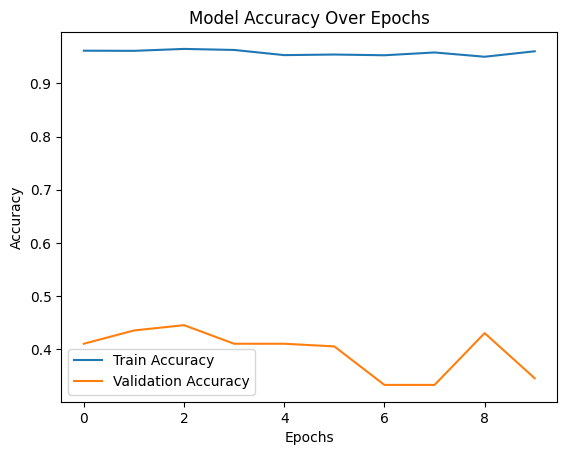

In [63]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.savefig("Model Accuracy over Epochs.png", dpi=300, bbox_inches='tight')
plt.show()


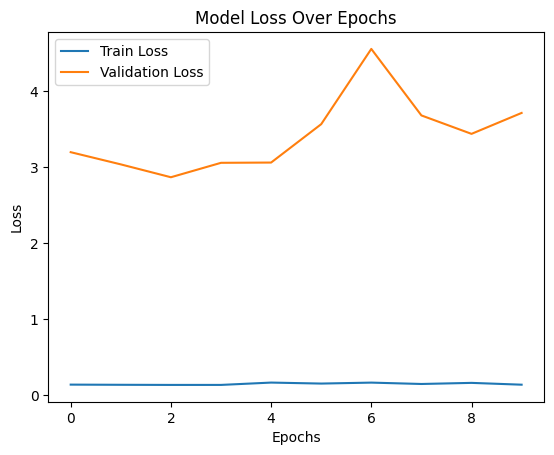

In [62]:
# Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.savefig("Model Loss over Epochs.png", dpi=300, bbox_inches='tight')
plt.show()


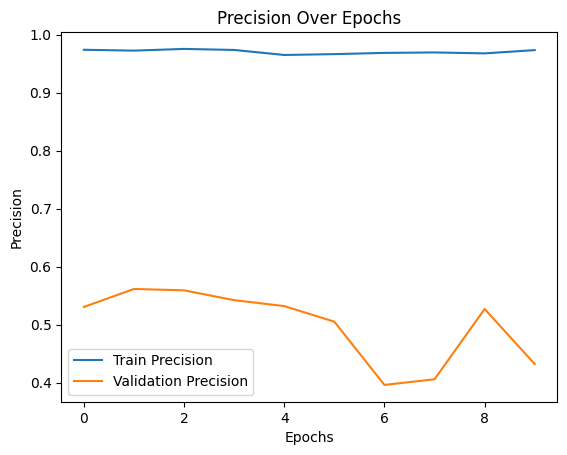

In [61]:
# Plot Precision
plt.plot(history.history['precision_2'], label='Train Precision')
plt.plot(history.history['val_precision_2'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()
plt.savefig("Precision over Epochs.png", dpi=300, bbox_inches='tight')
plt.show()



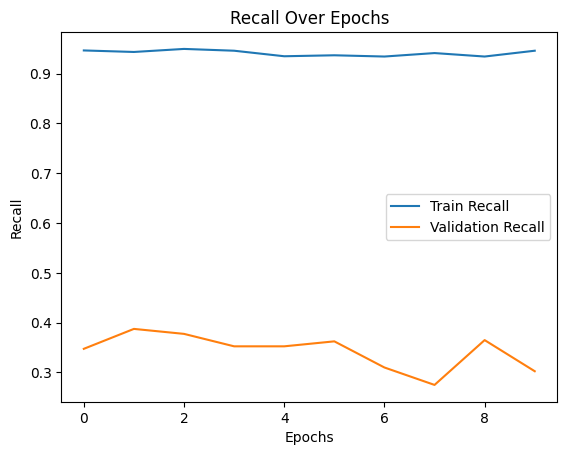

In [60]:

# Plot Recall
plt.plot(history.history['recall_2'], label='Train Recall')
plt.plot(history.history['val_recall_2'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall Over Epochs')
plt.legend()
plt.savefig("Recall Over Epochs.png", dpi=300, bbox_inches='tight')
plt.show()

13/13 [==============================] - 2s 158ms/step


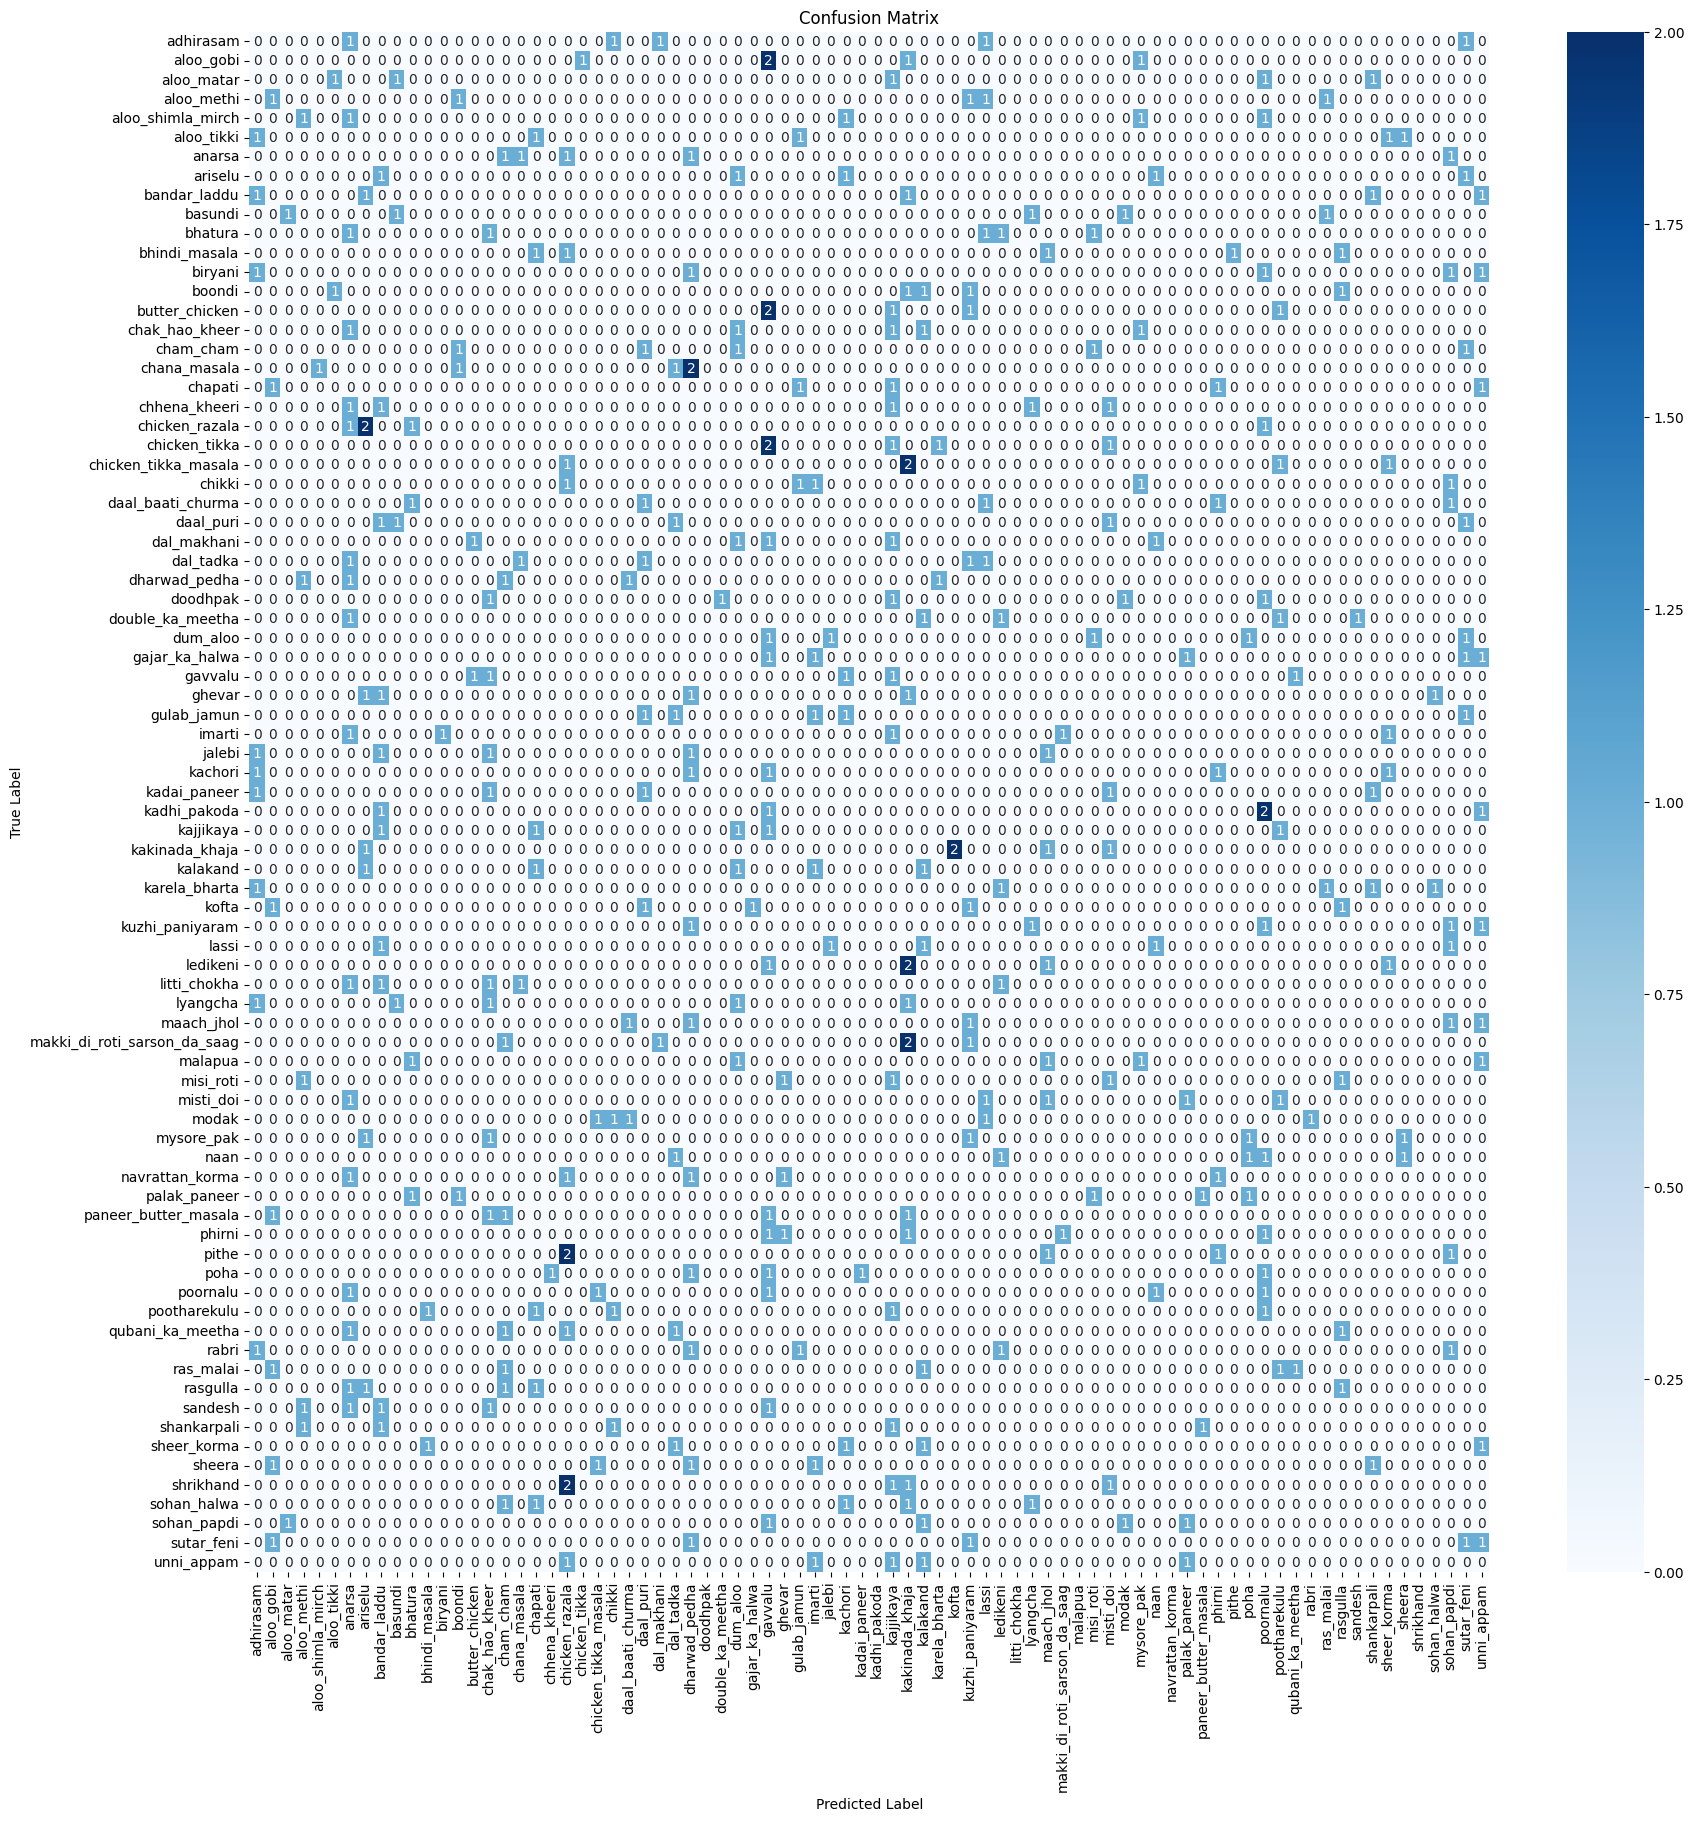

In [59]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_images.classes  # True labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()



In [64]:
def predict_food_and_nutrients_with_loaded_model(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict using the loaded model
    prediction = loaded_model.predict(img_array)
    predicted_class = loaded_encoder.inverse_transform([np.argmax(prediction)])[0]

    # Retrieve the nutrients for the predicted food
    nutrients = data[data['Food'] == predicted_class].iloc[:, 1:].to_dict('records')[0]
    return predicted_class, nutrients

# Example Usage
example_image = '000c3b0a6a.jpg'
predicted_food, predicted_nutrients = predict_food_and_nutrients_with_loaded_model(example_image)
print(f'Predicted Food: {predicted_food}')
print(f'Nutrients: {predicted_nutrients}')


1/1 [==============================] - 0s 40ms/step
Predicted Food: ariselu
Nutrients: {'Proteins (g)': 2.0, 'Carbs (g)': 32.0, ' Sugar (g)': 12.0, 'Fats (g)': 7.0}
